In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np

import sys


import sklearn.metrics as metrics

import shap

import argparse


import dataframe_image as dfi
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import sklearn
from sklearn.model_selection import KFold

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

from sklearn import tree

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.metrics import matthews_corrcoef

In [2]:
data_name = 'binarized_standard'
level = "species"

cv_num=5
tuning_fold_num = 5 
standard_pred = 0.5
display_num = 10

In [3]:

training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%(data_name,level,0))

feature_index_list = np.arange(1,training_features.shape[1]+1)
feature_name = np.arange(1,training_features.shape[1]+1)

In [4]:
# make array to save result for each prediction algorithm

model_name = ['Logistic Regression','Linear SVM','Random Forest','XGBoost','MLP-Perceptron','MLP-1 hidden layer','MLP-2 hidden layer','MLP-3 hidden layer']

feature_importance_total = np.zeros((len(model_name),len(feature_name),cv_num))

performance_name = ['AUC','Sensitivity','Specificity','PPV','NPV','Accuracy','MCC']
performance_total = np.zeros((len(model_name),len(performance_name),cv_num))

tpr_total = np.zeros((len(model_name),100,cv_num))


In [5]:
def performance_func(predicted_input,y_test_input,standard):
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test_input,predicted_input, pos_label=1)
    
    
    
    mean_fpr = np.linspace(0, 1, 100)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    
    temp = (predicted_input>standard).astype('int')
    cm=metrics.confusion_matrix(y_test_input, temp)

    # row가 진짜(0-음성, 1-양성), column이 예측(0-음성 1- 양성)
    TP = cm[1,1]
    FN = cm[1,0]
    FP = cm[0,1]
    TN = cm[0,0]
    # Sensitivity, hit rate, recall, or true positive rate
    sensitivity = TP/(TP+FN)
    # Specificity or true negative rate
    specificity = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return interp_tpr,metrics.auc(fpr, tpr),sensitivity,specificity,PPV,NPV,ACC

In [8]:
# data call 
for fold_num in range(cv_num):
    training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%(data_name,level,fold_num))
    training_label =np.load('../../Dataset/%s/%s/%s_training_label.npy'%("raw",level,fold_num))

    test_features = np.load('../../Dataset/%s/%s/%s_test_features.npy'%(data_name,level,fold_num))
    test_label =np.load('../../Dataset/%s/%s/%s_test_label.npy'%("raw",level,fold_num))

    #external dataset(4th dataset)
    if data_name=='raw':
        test_diff_features =  np.load('../../Dataset/raw/%s/external_features.npy'%(level))
    else:
        test_diff_features = np.load('../../Dataset/%s/%s/%s_test_diff_features.npy'%(data_name,level,fold_num))
        
        
    if data_name =="raw":
        scaler = StandardScaler()
        scaler.fit(training_features)
        training_features = scaler.transform(training_features)
        test_features = scaler.transform(test_features)
        test_diff_features = scaler.transform(test_diff_features)




    # make dataframe dataset to make it applicable to scikit-learn

    X_train = pd.DataFrame(training_features, columns = feature_index_list)
    X_test = pd.DataFrame(test_features, columns = feature_index_list)
    y_train =  training_label
    y_test  = test_label 

    X_diff_test = pd.DataFrame(test_diff_features, columns = feature_index_list)



    # Logistic Regression

    model_num = int(0)


    grid_parameters = pd.DataFrame({'C':[2**(i) for i in range(-5,5,2)]})
    tuned_parameters = pd.DataFrame()

    data = np.arange(training_label.shape[0])
    kfold = KFold(n_splits=cv_num,random_state=0, shuffle=True)

    average_MCC_each_grid = np.array([])

    for c in grid_parameters['C']:
        mcc_each_fold_each_grid = np.array([])
        for train, test in kfold.split(data):

            model_log = LogisticRegression(C=c, random_state= 0)
            model_log.fit(pd.DataFrame(training_features[data[train],:]),training_label[data[train]])
            y_pred = model_log.predict_proba(pd.DataFrame(training_features[data[test],:]))[:,1]>=standard_pred
            mcc_each_fold_each_grid = np.append(mcc_each_fold_each_grid,matthews_corrcoef(training_label[data[test]],y_pred))
        average_MCC_each_grid = np.append(average_MCC_each_grid,np.average(mcc_each_fold_each_grid)) 
    tuned_parameters = tuned_parameters.append({'C':grid_parameters['C'][np.argmax(average_MCC_each_grid)]},ignore_index=True)



    model_log = LogisticRegression(C=tuned_parameters['C'].loc[0], random_state=0)
    model_log.fit(X_train, y_train)

    # AUC 
    predicted = model_log.predict_proba(X_test)[:,1]

    tpr_total[model_num,:,fold_num],performance_total[model_num,0,fold_num],performance_total[model_num,1,fold_num],  \
    performance_total[model_num,2,fold_num],performance_total[model_num,3,fold_num],   \
    performance_total[model_num,4,fold_num],performance_total[model_num,5,fold_num]    = performance_func(predicted,y_test,standard_pred)

    performance_total[model_num,6,fold_num] = matthews_corrcoef(y_test,predicted>=standard_pred)
    print("Test set MCC: %s"%performance_total[model_num,6,fold_num])

    feature_importance_total[model_num,:,fold_num] += np.abs(model_log.coef_).reshape(-1,)


    # Linear SVM
    model_num = int(1)


    grid_parameters = pd.DataFrame({'C':[2**(i) for i in range(-5,15,2)]})
    tuned_parameters = pd.DataFrame()

    data = np.arange(training_label.shape[0])
    kfold = KFold(n_splits=cv_num,random_state=0, shuffle=True)

    average_MCC_each_grid = np.array([])

    for c in grid_parameters['C']:
        mcc_each_fold_each_grid = np.array([])
        for train, test in kfold.split(data):

            clf = svm.LinearSVC(C=c, max_iter = 10000,random_state = 0)                 
            clf.fit(pd.DataFrame(training_features[data[train],:]),training_label[data[train]])
            y_pred = clf.predict(pd.DataFrame(training_features[data[test],:]))>=standard_pred
            mcc_each_fold_each_grid = np.append(mcc_each_fold_each_grid,matthews_corrcoef(training_label[data[test]],y_pred))
        average_MCC_each_grid = np.append(average_MCC_each_grid,np.average(mcc_each_fold_each_grid)) 
    tuned_parameters = tuned_parameters.append({'C':grid_parameters['C'][np.argmax(average_MCC_each_grid)]},ignore_index=True)



    clf = svm.LinearSVC(C=tuned_parameters['C'].loc[0], max_iter = 10000,random_state = 0)           
    clf.fit(X_train, y_train)



    # AUC 
    predicted = clf.predict(X_test)
    tpr_total[model_num,:,fold_num],performance_total[model_num,0,fold_num],performance_total[model_num,1,fold_num],  \
    performance_total[model_num,2,fold_num],performance_total[model_num,3,fold_num],   \
    performance_total[model_num,4,fold_num],performance_total[model_num,5,fold_num]    = performance_func(predicted,y_test,standard_pred)


    performance_total[model_num,6,fold_num] = matthews_corrcoef(y_test,predicted>=standard_pred)

    print("Test set MCC: %s"%performance_total[model_num,6,fold_num])

    feature_importance_total[model_num,:,fold_num] += np.abs(clf.coef_[0,:]).reshape(-1,)



    # Random Forest

    model_num = int(2)



    model_randomforest = RandomForestClassifier(n_estimators=100,min_samples_leaf =2,
                                            random_state= fold_num)    
    model_randomforest.fit(X_train, y_train)
    predicted = model_randomforest.predict(X_test)



    tpr_total[model_num,:,fold_num],performance_total[model_num,0,fold_num],performance_total[model_num,1,fold_num],  \
    performance_total[model_num,2,fold_num],performance_total[model_num,3,fold_num],   \
    performance_total[model_num,4,fold_num],performance_total[model_num,5,fold_num]    = performance_func(predicted,y_test,standard_pred)

    performance_total[model_num,6,fold_num] = matthews_corrcoef(y_test,predicted>=standard_pred)
    print(performance_total[model_num,6,fold_num])
   
    feature_importance_total[model_num,:,fold_num] += model_randomforest.feature_importances_.reshape(-1,)


    explainer = shap.TreeExplainer(model_randomforest)
    shap_values = explainer.shap_values(X_train)  
    shap_values = shap_values[1]
    np.save("../classification/%s/%s/shap_values/%s_randomforest_shap_values.npy"%(level,data_name,fold_num),shap_values)

    shap_values = explainer.shap_values(X_test)  
    shap_values = shap_values[1]
    np.save("../classification/%s/%s/shap_values/%s_randomforest_shap_values_test.npy"%(level,data_name,fold_num),shap_values)


    shap_values = explainer.shap_values(X_diff_test)  
    shap_values = shap_values[1]
    np.save("../classification/%s/%s/shap_values/%s_randomforest_shap_values_test_diff.npy"%(level,data_name,fold_num),shap_values)



    # XGBoost

    model_num = int(3)


    grid_parameters_eta = pd.DataFrame({'ETA':[0.005,0.01, 0.05, 0.1, 0.5]})
    grid_parameters_alpha =  pd.DataFrame({'ALPHA':[1e-3, 1e-2, 0.1, 1,10]})

    average_MCC_each_grid = np.array([])

    data = np.arange(y_train.shape[0])
    kfold = KFold(n_splits=cv_num,random_state=0, shuffle=True)

    for eta in grid_parameters_eta['ETA']:
            for alpha in grid_parameters_alpha['ALPHA']:
                mcc_each_fold_each_grid = np.array([])
                for train, test in kfold.split(data):

                    model_xgboost = xgb.XGBRegressor(random_state=0,colsample_bytree = 0.5, \
                                 learning_rate = eta,verbosity = 1,\
    booster='gbtree',gamma=1,subsample=0.2,max_depth = 20, alpha = alpha, n_estimators = 200)
                    model_xgboost.fit(pd.DataFrame(X_train.to_numpy()[data[train],:]),y_train[data[train]])                        
                    y_pred = model_xgboost.predict(pd.DataFrame(X_train.to_numpy()[data[test],:]))>=standard_pred
                    mcc_each_fold_each_grid = np.append(mcc_each_fold_each_grid,matthews_corrcoef(y_train[data[test]],y_pred))
                average_MCC_each_grid = np.append(average_MCC_each_grid,np.average(mcc_each_fold_each_grid)) 
    index_eta =    int(np.argmax(average_MCC_each_grid)/5)
    index_alpha =    int(np.argmax(average_MCC_each_grid)%5)



     # parameter tuning 
    model_xgboost = xgb.XGBRegressor(random_state=0,colsample_bytree = 0.5, \
                                     learning_rate = grid_parameters_eta['ETA'][index_eta],verbosity = 1,\
    booster='gbtree',gamma=1,subsample=0.2,max_depth = 20, alpha = grid_parameters_alpha['ALPHA'][index_alpha], n_estimators = 200)

    model_xgboost.fit(X_train, y_train)
    predicted = model_xgboost.predict(X_test)
    tpr_total[model_num,:,fold_num],performance_total[model_num,0,fold_num],performance_total[model_num,1,fold_num],  \
    performance_total[model_num,2,fold_num],performance_total[model_num,3,fold_num],   \
    performance_total[model_num,4,fold_num],performance_total[model_num,5,fold_num]    = performance_func(predicted,y_test,standard_pred)


    performance_total[model_num,6,fold_num] = matthews_corrcoef(y_test,predicted>=standard_pred)
    print(performance_total[model_num,6,fold_num])

    feature_importance_total[model_num,:,fold_num] += model_xgboost.feature_importances_.reshape(-1,)


    explainer = shap.TreeExplainer(model_xgboost)
    shap_values = explainer.shap_values(X_train)  
    np.save("../classification/%s/%s/shap_values/%s_xgboost_shap_values.npy"%(level,data_name,fold_num),shap_values)

    shap_values = explainer.shap_values(X_test)  
    np.save("../classification/%s/%s/shap_values/%s_xgboost_shap_values_test.npy"%(level,data_name,fold_num),shap_values)


    shap_values = explainer.shap_values(X_diff_test)  
    np.save("../classification/%s/%s/shap_values/%s_xgboost_shap_values_test_diff.npy"%(level,data_name,fold_num),shap_values)


    # MLP-Perceptron

    model_num = int(4)




     # parameter tuning 
    model_perceptron = Perceptron(random_state=0)

    model_perceptron.fit(X_train, y_train)
    predicted = model_perceptron.predict(X_test)

    training_pred = model_perceptron.predict(X_train)
    standard = 0.5
    tpr_total[model_num,:,fold_num],performance_total[model_num,0,fold_num],performance_total[model_num,1,fold_num],  \
    performance_total[model_num,2,fold_num],performance_total[model_num,3,fold_num],   \
    performance_total[model_num,4,fold_num],performance_total[model_num,5,fold_num]    = performance_func(predicted,y_test,standard_pred)


    performance_total[model_num,6,fold_num] = matthews_corrcoef(y_test,predicted>=standard_pred)
    print(performance_total[model_num,6,fold_num])

    feature_importance_total[model_num,:,fold_num] += np.abs(model_perceptron.coef_).reshape(-1,)



    # MLP-1 hideen layer
    model_num = 5
    model_num = int(model_num)

    tprs = []
    aucs = []

    grid_parameters_eta = pd.DataFrame({'ETA':[0.005,0.01, 0.05, 0.1, 0.5]})
    grid_parameters_alpha =  pd.DataFrame({'ALPHA':[1e-3, 1e-2, 0.1, 1,10]})

    average_MCC_each_grid = np.array([])

    data = np.arange(y_train.shape[0])
    kfold = KFold(n_splits=cv_num,random_state=0, shuffle=True)

    for eta in grid_parameters_eta['ETA']:
            for alpha in grid_parameters_alpha['ALPHA']:
                mcc_each_fold_each_grid = np.array([])
                for train, test in kfold.split(data):

                    model_mlp = MLPRegressor(solver='lbfgs',random_state=0, hidden_layer_sizes=(test_features.shape[1]),
                           max_iter=150, activation='relu',early_stopping=True,
                           validation_fraction=0.1,
                                    learning_rate_init=eta, alpha=alpha)





                    model_mlp.fit(pd.DataFrame(X_train.to_numpy()[data[train],:]),y_train[data[train]])                        
                    y_pred = model_mlp.predict(pd.DataFrame(X_train.to_numpy()[data[test],:]))>=standard_pred
                    mcc_each_fold_each_grid = np.append(mcc_each_fold_each_grid,matthews_corrcoef(y_train[data[test]],y_pred))
                average_MCC_each_grid = np.append(average_MCC_each_grid,np.average(mcc_each_fold_each_grid)) 
    index_eta =    int(np.argmax(average_MCC_each_grid)/5)
    index_alpha =    int(np.argmax(average_MCC_each_grid)%5)





    # parameter tuning 
    model_mlp = MLPRegressor(solver='lbfgs',random_state=0, hidden_layer_sizes=(test_features.shape[1]),
                       max_iter=150, activation='relu',early_stopping=True,
                       validation_fraction=0.1,
                                learning_rate_init=grid_parameters_eta['ETA'][index_eta], alpha=grid_parameters_alpha['ALPHA'][index_alpha])

    model_mlp.fit(X_train, y_train)
    predicted = model_mlp.predict(X_test)

    training_pred = model_mlp.predict(X_train)
    tpr_total[model_num,:,fold_num],performance_total[model_num,0,fold_num],performance_total[model_num,1,fold_num],  \
    performance_total[model_num,2,fold_num],performance_total[model_num,3,fold_num],   \
    performance_total[model_num,4,fold_num],performance_total[model_num,5,fold_num]    = performance_func(predicted,y_test,standard_pred)


    performance_total[model_num,6,fold_num] = matthews_corrcoef(y_test,predicted>=standard_pred)
    print(performance_total[model_num,6,fold_num])

    feature_importance_total[model_num,:,fold_num] += np.average(np.abs(model_mlp.coefs_[0]),axis=1)

#     if mlp_shap_on:
#         explainer = shap.KernelExplainer(model_mlp.predict,X_train)
#         shap_values = explainer.shap_values(X_train)
#         np.save("../classification/%s/%s/shap_values/%s_mlp_shap_values.npy"%(level,data_name,fold_num),shap_values)

#         shap_values = explainer.shap_values(X_test)  
#         np.save("../classification/%s/%s/shap_values/%s_mlp_shap_values_test.npy"%(level,data_name,fold_num),shap_values)

#         shap_values = explainer.shap_values(X_diff_test)  
#         np.save("../classification/%s/%s/shap_values/%s_mlp_shap_values_test_diff.npy"%(level,data_name,fold_num),shap_values)




    # MLP-2 hidden layer

    model_num = int(6)


    grid_parameters_eta = pd.DataFrame({'ETA':[0.005,0.01, 0.05, 0.1, 0.5]})
    grid_parameters_alpha =  pd.DataFrame({'ALPHA':[1e-3, 1e-2, 0.1, 1,10]})

    average_MCC_each_grid = np.array([])

    data = np.arange(y_train.shape[0])
    kfold = KFold(n_splits=cv_num,random_state=0, shuffle=True)

    for eta in grid_parameters_eta['ETA']:
            for alpha in grid_parameters_alpha['ALPHA']:
                mcc_each_fold_each_grid = np.array([])
                for train, test in kfold.split(data):

                    model_mlp = MLPRegressor(solver='lbfgs',random_state=0, hidden_layer_sizes=(test_features.shape[1],test_features.shape[1]),
                           max_iter=150, activation='relu',early_stopping=True,
                           validation_fraction=0.1,
                                    learning_rate_init=eta, alpha=alpha)





                    model_mlp.fit(pd.DataFrame(X_train.to_numpy()[data[train],:]),y_train[data[train]])                        
                    y_pred = model_mlp.predict(pd.DataFrame(X_train.to_numpy()[data[test],:]))>=standard_pred
                    mcc_each_fold_each_grid = np.append(mcc_each_fold_each_grid,matthews_corrcoef(y_train[data[test]],y_pred))
                average_MCC_each_grid = np.append(average_MCC_each_grid,np.average(mcc_each_fold_each_grid)) 
    index_eta =    int(np.argmax(average_MCC_each_grid)/5)
    index_alpha =    int(np.argmax(average_MCC_each_grid)%5)




     # parameter tuning 
    model_mlp = MLPRegressor(solver='lbfgs',random_state=0, hidden_layer_sizes=(test_features.shape[1],test_features.shape[1]),
                       max_iter=150, activation='relu',early_stopping=True,
                       validation_fraction=0.1,
                                learning_rate_init=grid_parameters_eta['ETA'][index_eta], alpha=grid_parameters_alpha['ALPHA'][index_alpha])

    model_mlp.fit(X_train, y_train)
    predicted = model_mlp.predict(X_test)

    tpr_total[model_num,:,fold_num],performance_total[model_num,0,fold_num],performance_total[model_num,1,fold_num],  \
    performance_total[model_num,2,fold_num],performance_total[model_num,3,fold_num],   \
    performance_total[model_num,4,fold_num],performance_total[model_num,5,fold_num]    = performance_func(predicted,y_test,standard_pred)

    performance_total[model_num,6,fold_num] = matthews_corrcoef(y_test,predicted>=standard_pred)
    print(performance_total[model_num,6,fold_num])

    feature_importance_total[model_num,:,fold_num] += np.average(np.abs(model_mlp.coefs_[0]),axis=1)



    # MLP- 3 hidden layers
    model_num = int(7)


    grid_parameters_eta = pd.DataFrame({'ETA':[0.005,0.01, 0.05, 0.1, 0.5]})
    grid_parameters_alpha =  pd.DataFrame({'ALPHA':[1e-3, 1e-2, 0.1, 1,10]})

    average_MCC_each_grid = np.array([])

    data = np.arange(y_train.shape[0])
    kfold = KFold(n_splits=cv_num,random_state=0, shuffle=True)


    
    for eta in grid_parameters_eta['ETA']:
            for alpha in grid_parameters_alpha['ALPHA']:
                mcc_each_fold_each_grid = np.array([])
                for train, test in kfold.split(data):

                    model_mlp = MLPRegressor(solver='lbfgs',random_state=0, hidden_layer_sizes=(test_features.shape[1],test_features.shape[1],test_features.shape[1]),
                           max_iter=150, activation='relu',early_stopping=True,
                           validation_fraction=0.1,
                                    learning_rate_init=eta, alpha=alpha)





                    model_mlp.fit(pd.DataFrame(X_train.to_numpy()[data[train],:]),y_train[data[train]])                        
                    y_pred = model_mlp.predict(pd.DataFrame(X_train.to_numpy()[data[test],:]))>=standard_pred
                    mcc_each_fold_each_grid = np.append(mcc_each_fold_each_grid,matthews_corrcoef(y_train[data[test]],y_pred))
                average_MCC_each_grid = np.append(average_MCC_each_grid,np.average(mcc_each_fold_each_grid)) 
    index_eta =    int(np.argmax(average_MCC_each_grid)/5)
    index_alpha =    int(np.argmax(average_MCC_each_grid)%5)




     # parameter tuning 
    model_mlp = MLPRegressor(solver='lbfgs',random_state=0, hidden_layer_sizes=(test_features.shape[1],test_features.shape[1],test_features.shape[1]),
                       max_iter=150, activation='relu',early_stopping=True,
                       validation_fraction=0.1,
                                learning_rate_init=grid_parameters_eta['ETA'][index_eta], alpha=grid_parameters_alpha['ALPHA'][index_alpha])

    model_mlp.fit(X_train, y_train)
    predicted = model_mlp.predict(X_test)

    training_pred = model_mlp.predict(X_train)
    tpr_total[model_num,:,fold_num],performance_total[model_num,0,fold_num],performance_total[model_num,1,fold_num],  \
    performance_total[model_num,2,fold_num],performance_total[model_num,3,fold_num],   \
    performance_total[model_num,4,fold_num],performance_total[model_num,5,fold_num]    = performance_func(predicted,y_test,standard_pred)


    performance_total[model_num,6,fold_num] = matthews_corrcoef(y_test,predicted>=standard_pred)
    print(performance_total[model_num,6,fold_num])

    feature_importance_total[model_num,:,fold_num] += np.average(np.abs(model_mlp.coefs_[0]),axis=1)












The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Test set MCC: 0.8923472614096353


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
The frame.append method i

Test set MCC: 0.8990628411159063
0.8683128317985289
0.8437364048816446


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0.8419199533966107


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.955393773274594


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.8667818380444322


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.9051299730922368


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Test set MCC: 0.8715487933859306


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
The frame.append method i

Test set MCC: 0.8971232043676393
0.9294262254096376
0.92917380217667


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0.852281474341527


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.9227520070627785


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


0.9227520070627785


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.9100771584820253


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Test set MCC: 0.9300378870210662


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
The frame.append method i

Test set MCC: 0.8989852356863226
0.9239381776212968
0.8981408641077732


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0.8683471957451909


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.9620098178801176


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.93568239488042


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.9368368343780586


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Test set MCC: 0.8976977278513277


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
The frame.append method i

Test set MCC: 0.8976977278513277
0.865561129841025
0.8143088204402689


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0.8591254528836607


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.8912526031408675


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


0.8783824429257537


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


0.8783824429257537


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Test set MCC: 0.8445373554771715


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Test set MCC: 0.8705039755424323
0.8570491432040918
0.845938891120098


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0.8306699958385352


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.9090620141343644


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.8695755557733982


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

0.8826365336480614


# MLP-1hidden layer only

In [6]:
mlp_shap_on = True

In [ ]:
fold_num=0
training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%(data_name,level,fold_num))
training_label =np.load('../../Dataset/%s/%s/%s_training_label.npy'%("raw",level,fold_num))

test_features = np.load('../../Dataset/%s/%s/%s_test_features.npy'%(data_name,level,fold_num))
test_label =np.load('../../Dataset/%s/%s/%s_test_label.npy'%("raw",level,fold_num))

#external dataset(4th dataset)
if data_name=='raw':
    test_diff_features =  np.load('../../Dataset/raw/%s/external_features.npy'%(level))
else:
    test_diff_features = np.load('../../Dataset/%s/%s/%s_test_diff_features.npy'%(data_name,level,fold_num))


if data_name =="raw":
    scaler = StandardScaler()
    scaler.fit(training_features)
    training_features = scaler.transform(training_features)
    test_features = scaler.transform(test_features)
    test_diff_features = scaler.transform(test_diff_features)




# make dataframe dataset to make it applicable to scikit-learn

X_train = pd.DataFrame(training_features, columns = feature_index_list)
X_test = pd.DataFrame(test_features, columns = feature_index_list)
y_train =  training_label
y_test  = test_label 

X_diff_test = pd.DataFrame(test_diff_features, columns = feature_index_list)


# MLP-1 hideen layer
model_num = 5
model_num = int(model_num)



grid_parameters_eta = pd.DataFrame({'ETA':[0.005,0.01, 0.05, 0.1, 0.5]})
grid_parameters_alpha =  pd.DataFrame({'ALPHA':[1e-3, 1e-2, 0.1, 1,10]})

average_MCC_each_grid = np.array([])

data = np.arange(y_train.shape[0])
kfold = KFold(tuning_fold_num)

for eta in grid_parameters_eta['ETA']:
        for alpha in grid_parameters_alpha['ALPHA']:
            mcc_each_fold_each_grid = np.array([])
            for train, test in kfold.split(data):

                model_mlp = MLPRegressor(solver='lbfgs',random_state=0, hidden_layer_sizes=(test_features.shape[1]),
                       max_iter=150, activation='relu',early_stopping=True,
                       validation_fraction=0.1,
                                learning_rate_init=eta, alpha=alpha)





                model_mlp.fit(pd.DataFrame(X_train.to_numpy()[data[train],:]),y_train[data[train]])                        
                y_pred = model_mlp.predict(pd.DataFrame(X_train.to_numpy()[data[test],:]))>=standard_pred
                mcc_each_fold_each_grid = np.append(mcc_each_fold_each_grid,matthews_corrcoef(y_train[data[test]],y_pred))
            average_MCC_each_grid = np.append(average_MCC_each_grid,np.average(mcc_each_fold_each_grid)) 
index_eta =    int(np.argmax(average_MCC_each_grid)/5)
index_alpha =    int(np.argmax(average_MCC_each_grid)%5)





# parameter tuning 
model_mlp = MLPRegressor(solver='lbfgs',random_state=0, hidden_layer_sizes=(test_features.shape[1]),
                   max_iter=150, activation='relu',early_stopping=True,
                   validation_fraction=0.1,
                            learning_rate_init=grid_parameters_eta['ETA'][index_eta], alpha=grid_parameters_alpha['ALPHA'][index_alpha])

model_mlp.fit(X_train, y_train)
predicted = model_mlp.predict(X_test)

if mlp_shap_on:
    explainer = shap.KernelExplainer(model_mlp.predict,X_train)
#     shap_values = explainer.shap_values(X_train)
#     np.save("../classification/%s/%s/shap_values/%s_mlp_shap_values.npy"%(level,data_name,fold_num),shap_values)

#     shap_values = explainer.shap_values(X_test)  
#     np.save("../classification/%s/%s/shap_values/%s_mlp_shap_values_test.npy"%(level,data_name,fold_num),shap_values)

    shap_values = explainer.shap_values(X_diff_test)  
    np.save("../classification/%s/%s/shap_values/%s_mlp_shap_values_test_diff.npy"%(level,data_name,fold_num),shap_values)




lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

  0%|          | 0/444 [00:00<?, ?it/s]

# Save results

In [9]:
np.save("../classification/%s/%s/tpr_total.npy"%(level,data_name),tpr_total)
np.save("../classification/%s/%s/performance_total.npy"%(level,data_name),performance_total)
np.save("../classification/%s/%s/feature_importance_total.npy"%(level,data_name),feature_importance_total)

# Basic Graph

In [34]:
tpr_total = np.load("../classification/%s/%s/tpr_total.npy"%(level,data_name))
performance_total = np.load("../classification/%s/%s/performance_total.npy"%(level,data_name))
feature_importance_total = np.load("../classification/%s/%s/feature_importance_total.npy"%(level,data_name))

## Performance Table

In [20]:
performance_total_df= pd.DataFrame(columns=performance_name,index=model_name)

for index_model,name_model in enumerate(model_name):
    for index_per,name_per in enumerate(performance_name):
        performance_total_df.loc['%s'%name_model,'%s'%name_per] =\
        r'%0.3f ± %0.2f'%(np.average(performance_total[index_model,index_per,:]),np.std(performance_total[index_model,index_per,:]))


# dfi.export(performance_total_df,'../classification/%s/%s/performance table.jpg'%(level,data_name))

performance_total_df.to_excel('../classification/%s/%s/performance table.xlsx'%(level,data_name), index=False)

# performance_total_df

## Mean ROC curve

In [21]:
tpr_total = np.average(tpr_total, axis=2) 
for model_num in range(len(model_name)):
    tpr_total[model_num,:][-1] = 1.0

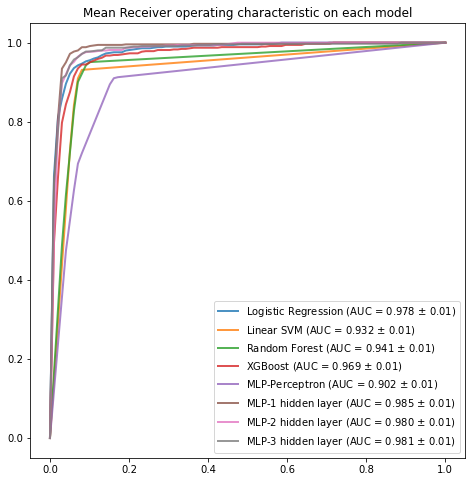

In [22]:
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1,1,figsize=(8,8))


for model_count in range(len(model_name)):

    mean_auc = metrics.auc(mean_fpr, tpr_total[model_count,:])
    std_auc = np.std(performance_total[index_model,0,:])
    ax.plot(
        mean_fpr,
         tpr_total[model_count,:],
        label=r"%s (AUC = %0.3f $\pm$ %0.2f)" % (model_name[model_count],mean_auc, std_auc),
        lw=2,
        alpha=0.8
    )
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
ax.set(

    title="Mean Receiver operating characteristic on each model"
)
ax.set_aspect('equal', adjustable='box')
ax.legend(loc="lower right")
plt.savefig('../classification/%s/%s/Mean Roc Curve.jpg'%(level,data_name), dpi=500, bbox_inches='tight')
plt.show()

# SHAP summary plot

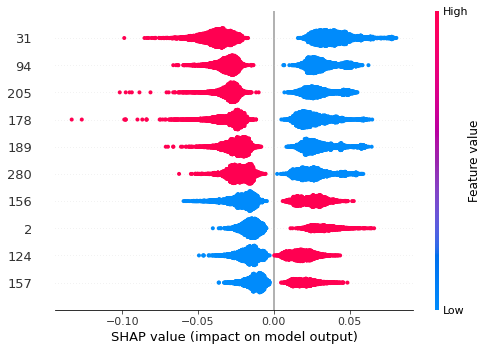

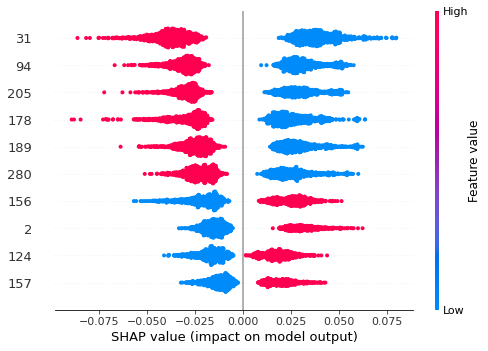

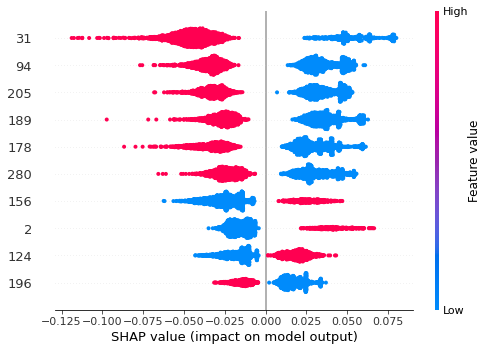

In [35]:
total_training_features = np.empty((0,len(feature_name)), float)
total_test_features = np.empty((0,len(feature_name)), float)
total_test_diff_features = np.empty((0,len(feature_name)), float)
total_randomforest_shap_values = np.empty((0,len(feature_name)), float)
total_randomforest_shap_values_test = np.empty((0,len(feature_name)), float)
total_randomforest_shap_values_test_diff = np.empty((0,len(feature_name)), float)



for fold_num in range(cv_num):

    training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%(data_name,level,fold_num))
    test_features = np.load('../../Dataset/%s/%s/%s_test_features.npy'%(data_name,level,fold_num))
    
    if data_name =="raw":
        test_diff_features =  np.load('../../Dataset/raw/%s/external_features.npy'%(level))
        scaler = StandardScaler()
        scaler.fit(training_features)
        training_features = scaler.transform(training_features)
        test_features = scaler.transform(test_features)
        test_diff_features = scaler.transform(test_diff_features)
    else:        
        test_diff_features =  np.load('../../Dataset/%s/%s/%s_test_diff_features.npy'%(data_name,level,fold_num))
        
    
    total_training_features = np.append(total_training_features,training_features,axis=0)
    total_test_features = np.append(total_test_features,test_features,axis=0)
    
    total_test_diff_features = np.append(total_test_diff_features,test_diff_features,axis=0)
    
    temp_randomforest_shap_values = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values.npy"%(level,data_name,fold_num)).copy()
    total_randomforest_shap_values = np.append(total_randomforest_shap_values,temp_randomforest_shap_values,axis=0)
    
    
    temp_randomforest_shap_values_test = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values_test.npy"%(level,data_name,fold_num)).copy()
    total_randomforest_shap_values_test = np.append(total_randomforest_shap_values_test,temp_randomforest_shap_values_test,axis=0)
    
    
    temp_randomforest_shap_values_test_diff = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values_test_diff.npy"%(level,data_name,fold_num)).copy()
    total_randomforest_shap_values_test_diff = np.append(total_randomforest_shap_values_test_diff,temp_randomforest_shap_values_test_diff,axis=0)
    
total_training_features_df = pd.DataFrame(total_training_features ,columns=feature_name) 
total_test_features_df = pd.DataFrame(total_test_features ,columns=feature_name) 
total_test_diff_features_df = pd.DataFrame(total_test_diff_features ,columns=feature_name) 


fig, ax = plt.subplots(1,1,figsize=(8,8))
shap.summary_plot(total_randomforest_shap_values,total_training_features_df, max_display=display_num)
fig.savefig('../classification/%s/%s/SHAP_summary_plot/randomforest_training.jpg'%(level,data_name), dpi=500, bbox_inches='tight')


fig, ax = plt.subplots(1,1,figsize=(8,8))
shap.summary_plot(total_randomforest_shap_values_test,total_test_features_df, max_display=display_num)
fig.savefig('../classification/%s/%s/SHAP_summary_plot/randomforest_test.jpg'%(level,data_name), dpi=500, bbox_inches='tight')

fig, ax = plt.subplots(1,1,figsize=(8,8))
shap.summary_plot(total_randomforest_shap_values_test_diff,total_test_diff_features_df, max_display=display_num)
fig.savefig('../classification/%s/%s/SHAP_summary_plot/randomforest_test_diff.jpg'%(level,data_name), dpi=500, bbox_inches='tight')



In [6]:
display_num=17

In [7]:
mlp_shap_on = True

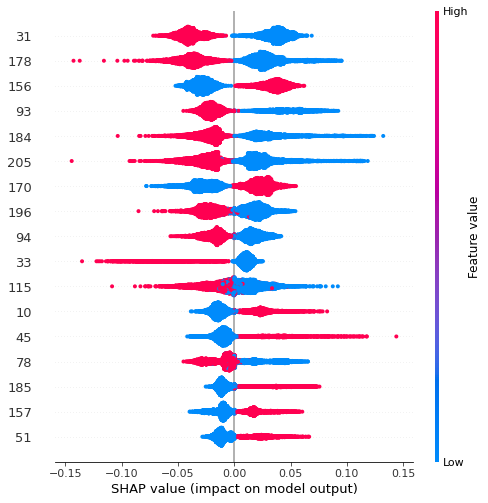

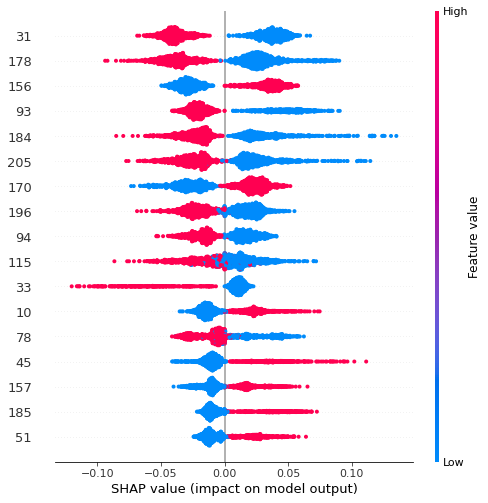

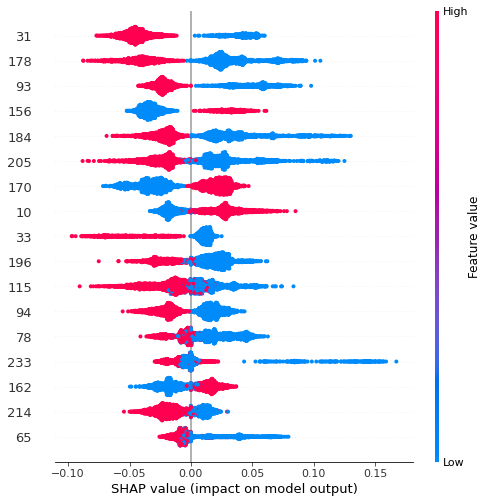

In [8]:
if mlp_shap_on:
    mlp_shap = np.load("../classification/%s/%s/shap_values/1_mlp_shap_values.npy"%(level,data_name))
    total_training_features = np.empty((0,len(feature_name)), float)
    total_test_features = np.empty((0,len(feature_name)), float)
    total_test_diff_features = np.empty((0,len(feature_name)), float)

    total_mlp_shap_values = np.empty((0,len(feature_name)), float)
    total_mlp_shap_values_test = np.empty((0,len(feature_name)), float)
    total_mlp_shap_values_test_diff = np.empty((0,len(feature_name)), float)

    temp = np.zeros(mlp_shap.shape)

    for fold_num in range(cv_num):
            
        training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%(data_name,level,fold_num))
        test_features = np.load('../../Dataset/%s/%s/%s_test_features.npy'%(data_name,level,fold_num))        
        test_diff_features =  np.load('../../Dataset/%s/%s/%s_test_diff_features.npy'%(data_name,level,fold_num))
        
        total_training_features = np.append(total_training_features,training_features,axis=0)
        total_test_features = np.append(total_test_features,test_features,axis=0)

        total_test_diff_features = np.append(total_test_diff_features,test_diff_features,axis=0)
        
        temp_mlp_shap_values = np.load("../classification/%s/%s/shap_values/%s_mlp_shap_values.npy"%(level,data_name,fold_num)).copy()
        total_mlp_shap_values = np.append(total_mlp_shap_values,temp_mlp_shap_values,axis=0)


        temp_mlp_shap_values_test = np.load("../classification/%s/%s/shap_values/%s_mlp_shap_values_test.npy"%(level,data_name,fold_num)).copy()
        total_mlp_shap_values_test = np.append(total_mlp_shap_values_test,temp_mlp_shap_values_test,axis=0)


        temp_mlp_shap_values_test_diff = np.load("../classification/%s/%s/shap_values/%s_mlp_shap_values_test_diff.npy"%(level,data_name,fold_num)).copy()
        total_mlp_shap_values_test_diff = np.append(total_mlp_shap_values_test_diff,temp_mlp_shap_values_test_diff,axis=0)

    total_training_features_df = pd.DataFrame(total_training_features ,columns=feature_name) 
    total_test_features_df = pd.DataFrame(total_test_features ,columns=feature_name) 
    total_test_diff_features_df = pd.DataFrame(total_test_diff_features ,columns=feature_name) 

    fig, ax = plt.subplots(1,1,figsize=(8,8))
    shap.summary_plot(total_mlp_shap_values,total_training_features_df, max_display=display_num)
    fig.savefig('../classification/%s/%s/SHAP_summary_plot/mlp_training.jpg'%(level,data_name), dpi=500, bbox_inches='tight')

    fig, ax = plt.subplots(1,1,figsize=(8,8))
    shap.summary_plot(total_mlp_shap_values_test,total_test_features_df, max_display=display_num)
    fig.savefig('../classification/%s/%s/SHAP_summary_plot/mlp_test.jpg'%(level,data_name), dpi=500, bbox_inches='tight')

    fig, ax = plt.subplots(1,1,figsize=(8,8))
    shap.summary_plot(total_mlp_shap_values_test_diff,total_test_diff_features_df, max_display=display_num)
    fig.savefig('../classification/%s/%s/SHAP_summary_plot/mlp_test_diff.jpg'%(level,data_name), dpi=500, bbox_inches='tight')


# Feature importance table

In [37]:
feature_importance_total = np.average(feature_importance_total,axis=2)

In [38]:
feature_importance_rank = pd.DataFrame()
feature_name_array = np.array(feature_name)

for index,name in enumerate(model_name):
    rank = feature_importance_total[index,:].argsort()[::-1]
    feature_importance_rank[name] =  feature_name_array[rank]
    

randomforest_shap = np.average(np.abs(total_randomforest_shap_values),axis=0)
randomforest_shap = randomforest_shap.reshape(len(feature_name),)
rank = randomforest_shap.argsort()[::-1]
feature_importance_rank['Random Forest-SHAP'] = feature_name_array[rank]
    
    
xgboost_shap = np.average(np.abs(total_xgboost_shap_values),axis=0)
xgboost_shap = xgboost_shap.reshape(len(feature_name),)
    
    
xgboost_shap = xgboost_shap.reshape(len(feature_name),)
rank = xgboost_shap.argsort()[::-1]
feature_importance_rank['XGBoost-SHAP'] = feature_name_array[rank]




feature_importance_rank.to_excel('../classification/%s/%s/feature importance table.xlsx'%(level,data_name), index=False)
# dfi.export(feature_importance_rank,'../classification/%s/%s/feature importance table.png'%(level,data_name),max_rows=50)
feature_importance_rank

,Logistic Regression,Linear SVM,Random Forest,XGBoost,MLP-Perceptron,MLP-1 hidden layer,MLP-2 hidden layer,MLP-3 hidden layer,Random Forest-SHAP,XGBoost-SHAP
0,33,33,31,94,33,178,184,238,31,31
1,31,31,94,31,60,184,8,66,94,94
2,93,60,205,205,31,115,183,74,205,205
3,60,93,189,189,232,205,178,222,178,2
4,170,170,178,280,93,183,205,76,189,156
...,...,...,...,...,...,...,...,...,...,...
278,145,182,34,167,182,82,82,101,97,151
279,41,146,81,62,278,88,147,114,81,268
280,81,145,137,63,81,182,235,147,274,245
281,182,282,126,151,40,70,101,102,126,21
